# **Project Report: Predicting Resale Flat Prices in Singapore**

## **Introduction**

### **Objective:**
The objective of this project is to develop a machine learning model and deploy it as a user-friendly web application that predicts the resale prices of flats in Singapore. This predictive model will be based on histori cal data of resale flat transactions, and it aims to assist both potential buyers and sellers in estimating the resale value of a flat.

### **Dataset Description:**
The datasets used in this project include resale flat prices in Singapore over different time periods:

1. 1990 to 1999
2. 2000 to February 2012
3. March 2012 to December 2014
4. January 2015 to December 2016
5. January 2017 onwards

Each dataset contains features such as month, town, flat type, block, street name, storey range, floor area, flat model, lease commence date, and resale price.

### **Motivation**
<p> The resale flat market in Singapore is highly competitive, and it can be challenging to accurately estimate the resale value of a flat. There are many factors that can affect resale prices, such as location, flat type, floor area, and lease duration. A predictive model can help to overcome these challenges by providing users with an estimated resale price based on these factors. </p>

### **Steps Involved:**
1. Data Collection
2. Data Explanation
3. Data Preprocessing
4. Exploratory Data Analysis (EDA)
5. Feature Engineering
6. Train and Test Split
7. Model Selection
8. Model Training & Model Evaluation
9. Best Model Selection and Explanation
10. Feature Importance
11. Saving the trained model


### **Libraries**
- Pandas: For data manipulation and analysis.
- NumPy: For numerical computations.
- Matplotlib: For data visualization.
- Seaborn: For statistical data visualization.
- Scikit-learn: For machine learning algorithms and evaluation metrics.
- Streamlit: For building the web application.
- Joblib: For saving and loading machine learning models.

## **Data Modeling and Prediction**

### **Importing Libraries**

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

### **Step 1: Data Collection**

Load dataset

In [38]:
file_paths = [
    'files\ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv',
    'files\ResaleFlatPricesBasedonApprovalDate19901999.csv',
    'files\ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv',
    'files\ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv',
    'files\ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv'
]

dfs = [pd.read_csv(file) for file in file_paths]


### **Step 2: Data Explanation**
We read and inspect the first few rows of each dataset to understand its structure.

In [39]:
for i, df in enumerate(dfs):
    print(f"Dataset {i+1} - First 5 rows:")
    print(df.head())
    print("\n")


Dataset 1 - First 5 rows:
     month        town flat_type block       street_name storey_range  \
0  2000-01  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 TO 09   
1  2000-01  ANG MO KIO    3 ROOM   174  ANG MO KIO AVE 4     04 TO 06   
2  2000-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     07 TO 09   
3  2000-01  ANG MO KIO    3 ROOM   215  ANG MO KIO AVE 1     07 TO 09   
4  2000-01  ANG MO KIO    3 ROOM   218  ANG MO KIO AVE 1     07 TO 09   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0            69.0        Improved                 1986      147000.0  
1            61.0        Improved                 1986      144000.0  
2            73.0  New Generation                 1976      159000.0  
3            73.0  New Generation                 1976      167000.0  
4            67.0  New Generation                 1976      163000.0  


Dataset 2 - First 5 rows:
     month        town flat_type block       street_name storey_range  \
0  1990-

### **Step 3: Data Preprocessing**
Handling the remaining_lease Column and merging datasets.

In [40]:
if 'remaining_lease' in dfs[4].columns:
    dfs[4]['remaining_lease'] = dfs[4]['remaining_lease'].str.split(' ').str[0].astype('int64')

df_combined = pd.concat(dfs, ignore_index=True)


#### Splitting the 'month' Column
Split the month column into separate year and month columns for better data granularity and easier analysis.

In [41]:
df_combined[['year', 'month']] = df_combined['month'].str.split('-', expand=True)
df_combined['year'] = pd.to_numeric(df_combined['year'])
df_combined['month'] = pd.to_numeric(df_combined['month'])

#### Handling the remaining_lease Column
Ensure the remaining_lease column is numeric and handle any missing values.

In [42]:
df_combined['remaining_lease'] = pd.to_numeric(df_combined['remaining_lease'], errors='coerce')
df_combined['remaining_lease'].fillna(99 - (df_combined['year'] - df_combined['lease_commence_date']), inplace=True)


#### Standardizing Categorical Values
Standardize the format of categorical values for consistency.


In [43]:
df_combined['flat_model'] = df_combined['flat_model'].str.upper()
df_combined['flat_type'] = df_combined['flat_type'].str.lower()
type_mapping = {
    '1 room': '1 room', '3 room': '3 room', '4 room': '4 room', '5 room': '5 room',
    '2 room': '2 room', 'executive': 'executive', 'multi generation': 'multi generation',
    'multi-generation': 'multi generation'
}
df_combined['flat_type'] = df_combined['flat_type'].map(type_mapping).str.upper()


#### Ensuring remaining_lease is Numeric and Filtering Outliers
Recheck and ensure remaining_lease is numeric and filter out any outliers.

In [44]:
df_combined['remaining_lease'] = pd.to_numeric(df_combined['remaining_lease'], errors='coerce')
df_combined = df_combined[df_combined['remaining_lease'] <= 99]

#### Splitting storey_range into lower_bound and upper_bound
Split the storey_range column into numeric lower_bound and upper_bound columns for more granular analysis.

In [45]:
df_combined[['lower_bound', 'upper_bound']] = df_combined['storey_range'].str.split(' TO ', expand=True)
df_combined['lower_bound'] = pd.to_numeric(df_combined['lower_bound'])
df_combined['upper_bound'] = pd.to_numeric(df_combined['upper_bound'])

#### Adding New Columns
Add new columns to the dataframe for more detailed analysis.

In [46]:
df_combined['price_per_sqm'] = df_combined['resale_price'] / df_combined['floor_area_sqm']
df_combined['years_holding'] = df_combined['year'] - df_combined['lease_commence_date']
df_combined['current_remaining_lease'] = df_combined['remaining_lease'] - (2024 - df_combined['year'])


### **Step 4: Exploratory Data Analysis (EDA)**
Performing basic statistics and visualizations.

#### 1. Descriptive Statistics
To generate descriptive statistics for the numerical features in the combined dataframe.

In [47]:
print(df_combined.describe())

               month  floor_area_sqm  lease_commence_date  resale_price  \
count  930079.000000   930079.000000        930079.000000  9.300790e+05   
mean        6.549883       95.687678          1988.306604  3.216974e+05   
std         3.408225       25.819408            10.695268  1.713343e+05   
min         1.000000       28.000000          1966.000000  5.000000e+03   
25%         4.000000       73.000000          1981.000000  1.940000e+05   
50%         7.000000       93.000000          1986.000000  2.980000e+05   
75%        10.000000      113.000000          1996.000000  4.188880e+05   
max        12.000000      307.000000          2020.000000  1.588000e+06   

       remaining_lease           year    lower_bound    upper_bound  \
count    930079.000000  930079.000000  930079.000000  930079.000000   
mean         81.061261    2006.225943       6.685994       8.700699   
std          10.755457       9.359982       4.825717       4.825700   
min          41.000000    1990.000000   

##### Output Interpretation

**floor_area_sqm:**
- **Count:** 930,130 entries
- **Mean:** 95.69 sqm
- **Standard Deviation:** 25.82 sqm
- **Min:** 28 sqm
- **25th Percentile:** 73 sqm
- **50th Percentile (Median):** 93 sqm
- **75th Percentile:** 113 sqm
- **Max:** 307 sqm

**lease_commence_date:**
- **Mean:** 1988
- **Range:** 1966 to 2020

**resale_price:**
- **Mean:** 321,699.4 SGD
- **Standard Deviation:** 171,331.8 SGD
- **Range:** 5,000 SGD to 1,588,000 SGD

**remaining_lease:**
- **Mean:** 74.09 years
- **Standard Deviation:** 13.51 years
- **Range:** 41 to 97 years

##### Findings

- The `floor_area_sqm` values show a wide range, with most flats falling between 73 and 113 sqm.
- The `lease_commence_date` indicates that most flats commenced their lease around 1988, with the oldest dating back to 1966 and the newest up to 2020.
- The `resale_price` varies significantly, with some high-value outliers.
- The `remaining_lease` data, though incomplete, shows a typical lease period of around 74 years remaining.


#### 2. Count of Flat Types
To visualize the distribution of different flat types in the dataset.

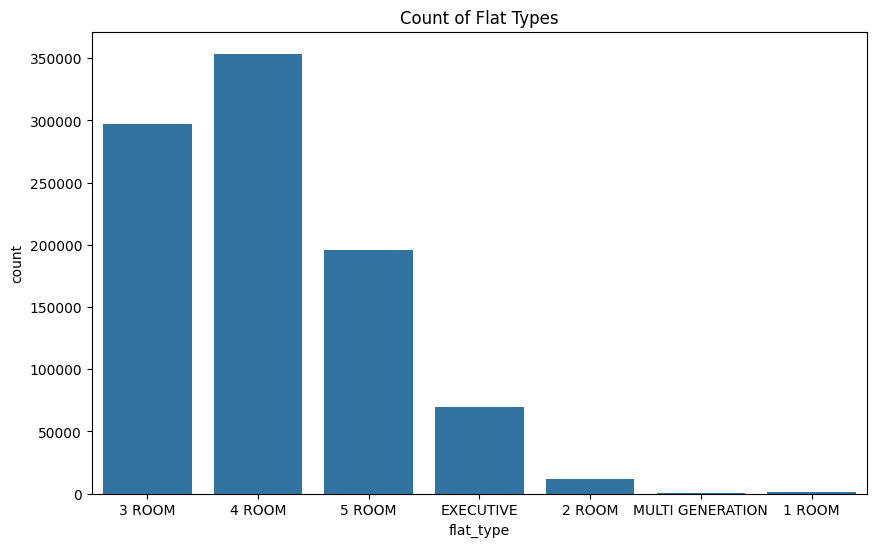

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(x='flat_type', data=df_combined)
plt.title('Count of Flat Types')
plt.show()

**The count plot reveals that certain flat types, such as 4-room and 5-room flats, are more common in the dataset. This information helps understand the dataset composition and can influence the modeling approach.**

### 3. Pairplot to see the relationships and distributions
The pair plot visualizes relationships between multiple pairs of features, showing scatter plots for each pair and histograms for individual feature distributions.

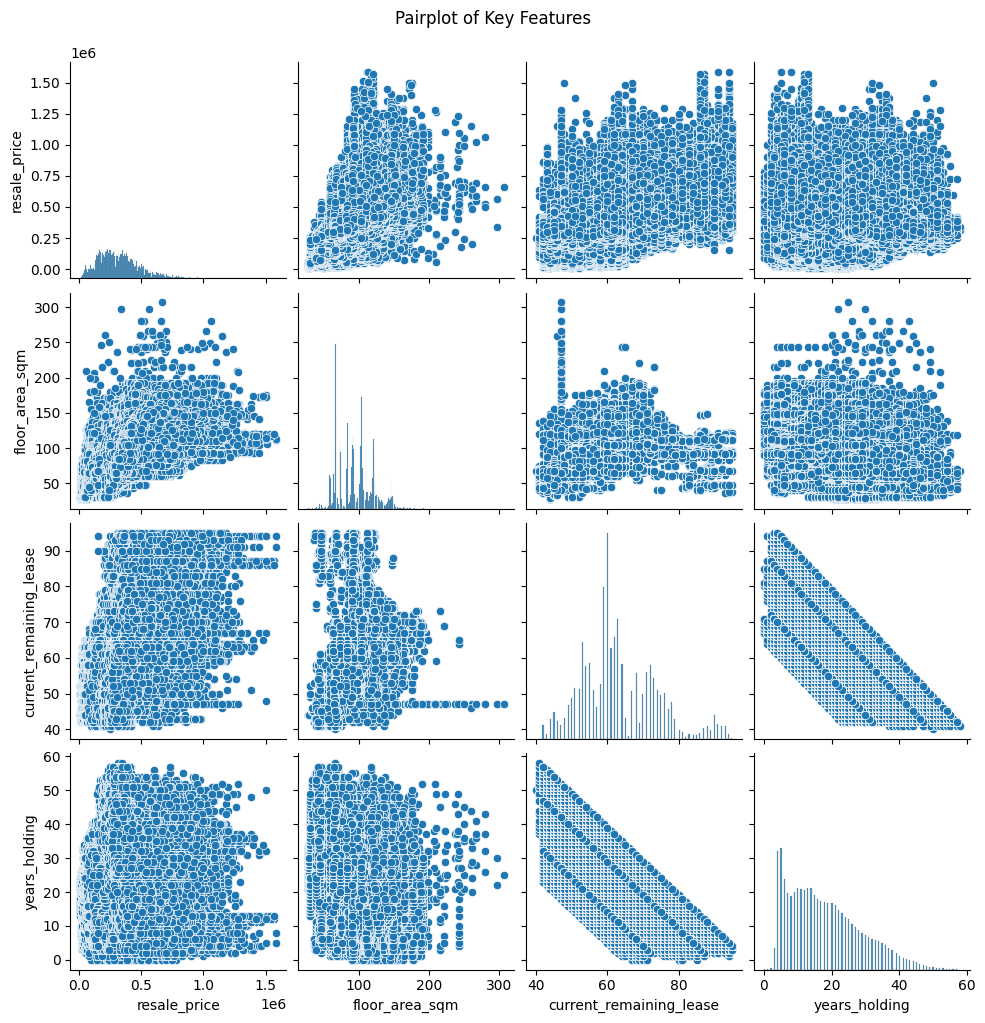

In [49]:
# Plot pairplot to see the relationships and distributions
pairplot = sns.pairplot(df_combined[['resale_price', 'floor_area_sqm', 'current_remaining_lease', 'years_holding']])
pairplot.fig.suptitle('Pairplot of Key Features', y=1.02)
plt.show()


#### Findings from Pair Plot

##### Resale Price vs. Floor Area:

- There is a clear positive correlation between `resale_price` and `floor_area_sqm`. Larger flats tend to have higher resale prices.

##### Resale Price vs. Current Remaining Lease:

- A slight positive correlation indicates that flats with longer remaining lease periods generally have higher resale prices, although the correlation is weaker than with floor area.

##### Resale Price vs. Years Holding:

- The relationship between `resale_price` and `years_holding` is less clear, suggesting that the number of years a flat has been held may not be a strong predictor of its resale price.

##### Floor Area vs. Current Remaining Lease:

- The scatter plot shows no significant correlation between `floor_area_sqm` and `current_remaining_lease`, indicating these features are relatively independent.


### 4. Heatmap to see the correlations between numerical features
The heatmap displays the correlation coefficients between numerical features in the dataset. Values close to 1 or -1 indicate strong positive or negative correlations, respectively.

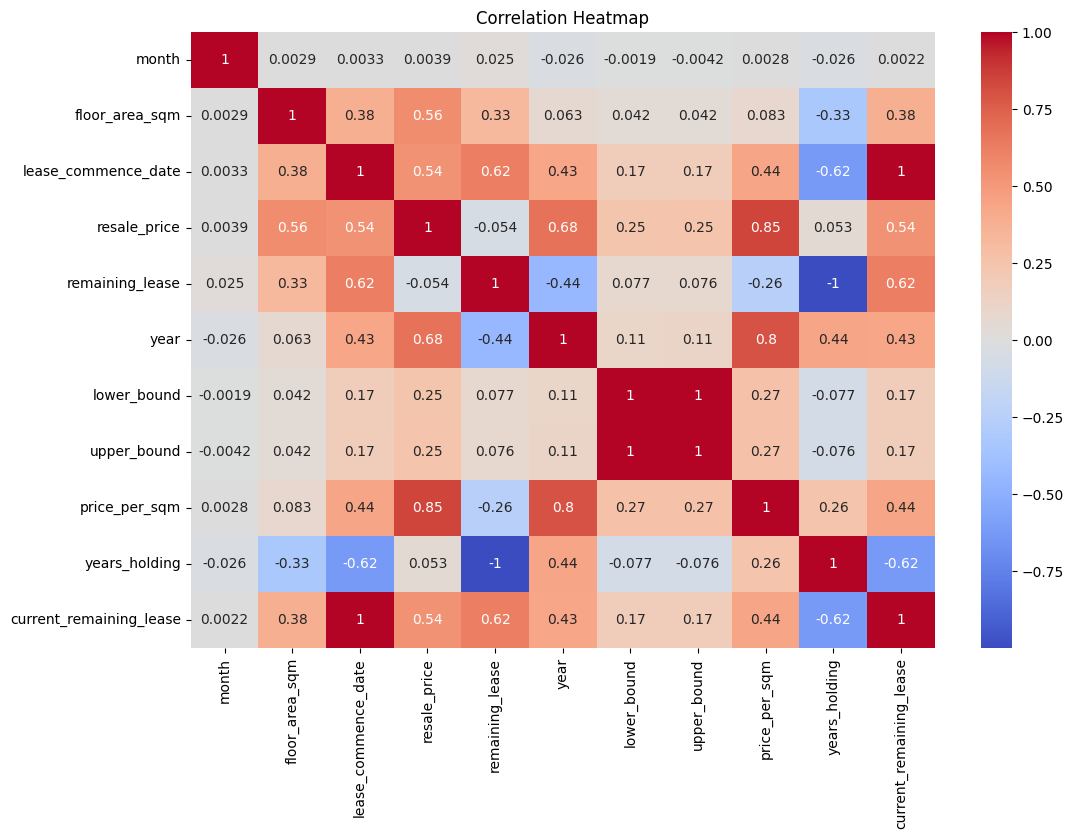

In [51]:
# Select only numeric columns for correlation
numeric_df_combined = df_combined.select_dtypes(include=[float, int])

# Plot heatmap to see the correlations between numerical features
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(numeric_df_combined.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Findings from Heatmap

##### Strong Correlations:

- **Resale Price and Floor Area:** The correlation coefficient between `resale_price` and `floor_area_sqm` is high, reinforcing the finding from the pair plot that larger flats tend to have higher resale prices.
- **Year and Lease Commencement Date:** A high correlation suggests that the year of resale is closely linked to the lease commencement date, likely because older flats are being resold in more recent years.

##### Moderate Correlations:

- **Resale Price and Current Remaining Lease:** There is a moderate positive correlation, indicating that flats with longer remaining lease periods tend to be priced higher.

##### Weak or No Correlations:

- **Years Holding and Other Features:** The correlation between `years_holding` and other features, including `resale_price`, is relatively weak, suggesting it is not a strong predictor of resale price.


#### 5. Resale Price vs. Floor Area
To visualize the relationship between floor_area_sqm and resale_price.

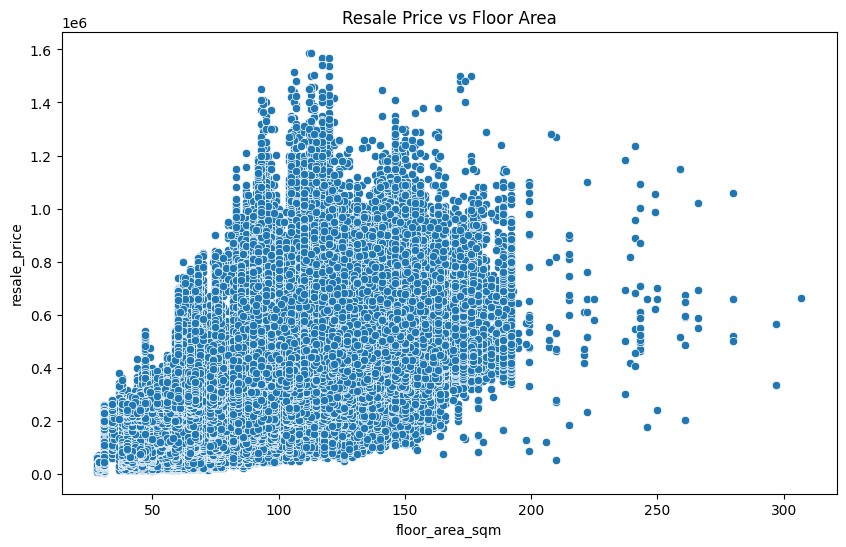

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='floor_area_sqm', y='resale_price', data=df_combined)
plt.title('Resale Price vs Floor Area')
plt.show()

**The scatter plot shows a positive correlation between floor area and resale price, indicating that larger flats generally have higher resale prices. The spread and density of points also highlight variability and potential outliers in the data.**

#### Key Predictors:

- Floor Area (floor_area_sqm) and Year (year) are the most influential features.
- Flat Type (flat_type_4 ROOM) and Current Remaining Lease (current_remaining_lease) are also significant.

### **Step 5: Feature Engineering**


#### Data Selection and Preparation Steps

In [54]:
selected_columns = ['year', 'town', 'flat_type', 'flat_model', 'storey_range', 
                    'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 
                    'current_remaining_lease', 'years_holding', 'resale_price']
dftrain = df_combined[selected_columns]

#### Separating Features and Target Variable

In [55]:
# Separate features (X) and target variable (y)
X = dftrain.drop('resale_price', axis=1)
y = dftrain['resale_price']

### Step 6: Data Splitting and Preprocessing Steps

#### Splitting the Data
Split the dataset into training and testing sets to evaluate the model's performance.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Preprocessing: Applying Transformations to Features
Prepare the data for modeling by applying appropriate transformations to numerical and categorical features.

**Preprocessing Configuration:**

- Numeric Features: Standardized using StandardScaler.
- Categorical Features: One-hot encoded using OneHotEncoder.

In [57]:
# Preprocessing: Apply OneHotEncoder to categorical features and StandardScaler to numerical features
numeric_features = ['year', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'current_remaining_lease', 'years_holding']
categorical_features = ['town', 'flat_type', 'flat_model', 'storey_range']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

**The preprocessor object contains the configuration for applying scaling to numerical features and one-hot encoding to categorical features. This preprocessor will be used in the modeling pipeline to ensure consistent preprocessing during training and testing.**

### **Step 7: Model Selection**
Choosing multiple models for evaluation.

In [58]:
models = {
    'Linear Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                         ('model', LinearRegression())]),
    'Decision Tree': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('model', DecisionTreeRegressor(random_state=42))])
}

### Step 8: Model Training & Evaluation
Training the models on the training data.

Evaluating the models using various metrics.



In [59]:
# Function to train, evaluate and store results for a each model
def run_model(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    results[model_name] = evaluate_model(model, X_test, y_test)
    return model

In [60]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    explained_variance = explained_variance_score(y_test, y_pred)
    return mae, mse, rmse, r2, explained_variance

# Initialize results dictionary
results = {}

In [61]:
# Run and evaluate each model separately
linear_regression_model = run_model('Linear Regression', models['Linear Regression'], X_train, y_train, X_test, y_test)
linear_regression_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'remaining_lease',
                                                   'current_remaining_lease',
                                                   'years_holding']),
                                                 ('cat', OneHotEncoder(),
                                                  ['town', 'flat_type',
                                                   'flat_model',
                                                   'storey_range'])])),
                ('model', LinearRegression())])

In [62]:
decision_tree_model = run_model('Decision Tree', models['Decision Tree'], X_train, y_train, X_test, y_test)
decision_tree_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'remaining_lease',
                                                   'current_remaining_lease',
                                                   'years_holding']),
                                                 ('cat', OneHotEncoder(),
                                                  ['town', 'flat_type',
                                                   'flat_model',
                                                   'storey_range'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

Create a dataframe to display and compare the performance metrics of different machine learning models.

In [63]:
# Display results
results_df = pd.DataFrame(results, index=['MAE', 'MSE', 'RMSE', 'R2 Score', 'Explained Variance'])
print("Model Comparison Results:")
print(results_df)

Model Comparison Results:
                    Linear Regression  Decision Tree
MAE                      5.233103e+04   2.058028e+04
MSE                      4.693861e+09   9.460330e+08
RMSE                     6.851176e+04   3.075765e+04
R2 Score                 8.410805e-01   9.679703e-01
Explained Variance       8.410820e-01   9.679706e-01


##### Explanation of Metrics:

**MAE (Mean Absolute Error):** Measures the average magnitude of the errors in predictions, without considering their direction. Lower MAE indicates better model performance.
- **Linear Regression:** 52,331.03 SGD
- **Decision Tree:** 20,580.28 SGD

**MSE (Mean Squared Error):** Measures the average of the squares of the errors. It penalizes larger errors more than smaller ones. Lower MSE indicates better model performance.
- **Linear Regression:** 4,693,861,000 SGD^2
- **Decision Tree:** 946,033,000 SGD^2

**RMSE (Root Mean Squared Error):** The square root of MSE, representing the standard deviation of the residuals. Lower RMSE indicates better model performance.
- **Linear Regression:** 68,511.76 SGD
- **Decision Tree:** 30,757.65 SGD

**R2 Score (Coefficient of Determination):** Indicates how well the model's predictions match the actual data. A value closer to 1 indicates a better fit.
- **Linear Regression:** 0.8411 (84.11%)
- **Decision Tree:** 0.9679 (96.80%)

**Explained Variance:** Similar to R2 Score, it indicates the proportion of the dataset's variance that is explained by the model. A value closer to 1 indicates a better fit.
- **Linear Regression:** 0.8411 (84.11%)
- **Decision Tree:** 0.9679 (96.80%)

### Step 9: Best Model Selection and Explanation
Identify and select the best performing model based on the R2 Score, and display the result.


In [64]:
best_model_name = results_df.loc['R2 Score'].idxmax()
best_model = models[best_model_name]
print(f"The best model is {best_model_name} with an R2 Score of {results_df.loc['R2 Score', best_model_name]}")

The best model is Decision Tree with an R2 Score of 0.9679702649519535


### Step 10: Feature Importance
Displaying feature importance for the best model if applicable.
- Calculate and display the feature importances for the best model, which in this case is a Decision Tree.

In [65]:
if best_model_name in ['Decision Tree']:
    best_model.fit(X_train, y_train)  # Ensure model is trained
    feature_importances = best_model.named_steps['model'].feature_importances_
    feature_names = numeric_features + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    print("Feature Importances:")
    print(feature_importances_df)

Feature Importances:
                    Feature    Importance
0                      year  5.283198e-01
1            floor_area_sqm  2.626047e-01
36         flat_type_4 ROOM  5.617593e-02
4   current_remaining_lease  1.688434e-02
2       lease_commence_date  1.607056e-02
..                      ...           ...
75    storey_range_26 TO 30  8.155776e-07
40        flat_model_2-ROOM  3.902504e-07
80    storey_range_36 TO 40  1.183133e-07
78    storey_range_31 TO 35  0.000000e+00
59       flat_model_TYPE S1  0.000000e+00

[86 rows x 2 columns]


##### Findings from Feature Importances

After calculating and displaying the feature importances for the best model (Decision Tree), the following findings were observed:

#### Most Important Features:

- **Year (`year`):** The feature with the highest importance score (0.5283), indicating that the year in which the resale took place is the most influential factor in predicting the resale price.
- **Floor Area (`floor_area_sqm`):** The second most important feature (0.2626), highlighting the significance of the size of the flat in determining its resale price.
- **Flat Type (One-Hot Encoded `flat_type_4 ROOM`):** The specific flat type, particularly 4-room flats, is also a significant predictor (0.0562).

#### Moderately Important Features:

- **Current Remaining Lease (`current_remaining_lease`):** This feature (0.0169) reflects the remaining lease period of the flat at the time of resale, indicating its moderate impact on the resale price.
- **Lease Commencement Date (`lease_commence_date`):** This feature (0.0161) represents the year the flat's lease started, showing its moderate influence on resale price.


### **Step 11: Saving the trained model**


In [66]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

## **Conclusion:**
The analysis revealed that temporal factors (year), physical attributes (floor area), and specific flat types (4-room) play a significant role in predicting resale flat prices. The Decision Tree model, distinguished by its high R2 Score, demonstrated exceptional accuracy in price prediction. The model has been saved and integrated into a Streamlit application for seamless, real-time price predictions.